## World Happiness Report - EDA

In this notebook main focus is on the .csv file that contains historical metric data of the countries previous to 2021.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import ipywidgets as widgets
from IPython.display import display

### Reading in the data

In [2]:
data = pd.read_csv("data/world-happiness-report.csv")

In [3]:
data.shape

(1949, 11)

In [4]:
data.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [5]:
data.isna().sum()

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         32
Generosity                           89
Perceptions of corruption           110
Positive affect                      22
Negative affect                      16
dtype: int64

Although there are no missing values in 'year', many countries are actually missing data from some years.

In [6]:
years_missing_df = pd.DataFrame({'country': data['Country name'].unique()})

In [7]:
for year in sorted(data['year'].unique()):
    
    years_missing_df[f'missing_{year}'] = 0

In [8]:
for country in data['Country name'].unique():
    
    country_data = data[data['Country name'] == country]
    
    years_present = country_data['year'].to_list()
    
    for year in sorted(data['year'].unique()):
        
        if year not in years_present:
            
            years_missing_df.loc[years_missing_df['country'] == country, f'missing_{year}'] = 1
            

In [9]:
years_missing_df.head()

,country,missing_2005,missing_2006,missing_2007,missing_2008,missing_2009,missing_2010,missing_2011,missing_2012,missing_2013,missing_2014,missing_2015,missing_2016,missing_2017,missing_2018,missing_2019,missing_2020
0,Afghanistan,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Albania,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Algeria,1,1,1,1,1,0,0,0,1,0,1,0,0,0,0,1
3,Angola,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1
4,Argentina,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Sum up the number of countries with missing data for each year
missing_counts = years_missing_df.drop(columns=['country']).sum()

In [11]:
missing_counts

missing_2005    139
missing_2006     77
missing_2007     64
missing_2008     56
missing_2009     52
missing_2010     42
missing_2011     20
missing_2012     24
missing_2013     29
missing_2014     21
missing_2015     23
missing_2016     24
missing_2017     19
missing_2018     24
missing_2019     22
missing_2020     71
dtype: int64

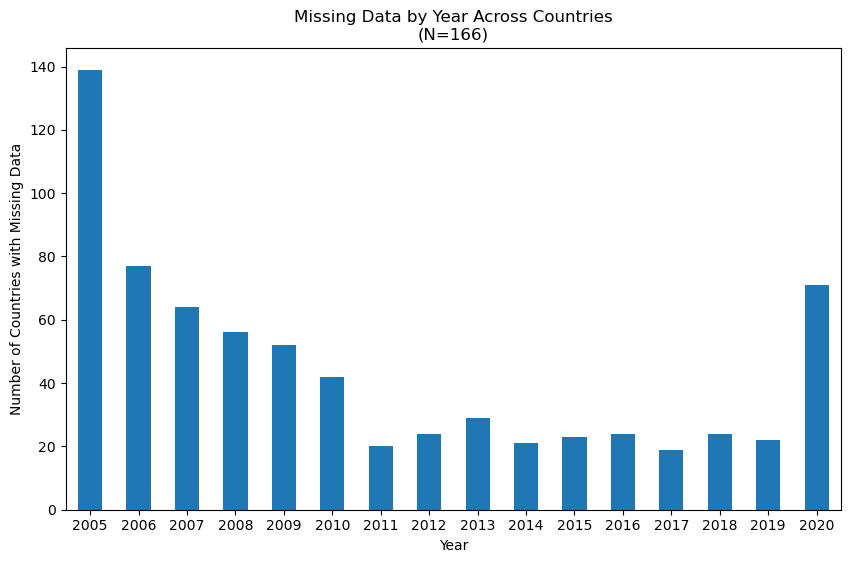

In [12]:
plt.figure(figsize=(10, 6))
ax = missing_counts.plot(kind='bar')

# Adjust x-tick labels to remove 'missing_' prefix
ax.set_xticklabels([label.replace('missing_', '') for label in missing_counts.index], rotation = 0)

plt.xlabel('Year')
plt.ylabel('Number of Countries with Missing Data')
plt.title('Missing Data by Year Across Countries\n(N=166)')

plt.show()

Reading in the geodata for plotting.

In [13]:
countries = gpd.read_file('data/world-administrative-boundaries/world-administrative-boundaries.shp')

In [14]:
countries.head()

,iso3,status,color_code,name,continent,region,iso_3166_1_,french_shor,geometry
0,UGA,Member State,UGA,Uganda,Africa,Eastern Africa,UG,Ouganda,"POLYGON ((33.92110 -1.00194, 33.92027 -1.00111..."
1,UZB,Member State,UZB,Uzbekistan,Asia,Central Asia,UZ,Ouzbékistan,"POLYGON ((70.97081 42.25467, 70.98054 42.26205..."
2,IRL,Member State,IRL,Ireland,Europe,Northern Europe,IE,Irlande,"MULTIPOLYGON (((-9.97014 54.02083, -9.93833 53..."
3,ERI,Member State,ERI,Eritrea,Africa,Eastern Africa,ER,Érythrée,"MULTIPOLYGON (((40.13583 15.75250, 40.12861 15..."
4,None,UK Territory,GBR,South Georgia & the South Sandwich Islands,Antarctica,None,None,South Georgia & the South Sandwich Islands,"MULTIPOLYGON (((-26.24361 -58.49473, -26.24889..."


Making a more informative version of the plot above.

In [15]:
years_missing_df = pd.merge(years_missing_df, countries[['name','continent', 'region']], left_on='country', right_on='name', how='left').drop(columns=['name'])

In [16]:
years_missing_df_long = years_missing_df.melt(id_vars=['country', 'continent', 'region'], 
                  var_name='year', 
                  value_name='missing')

#Now, group by year and continent, summing the missing values
years_missing_df_grouped = years_missing_df_long.groupby(['year', 'continent']).sum().reset_index()

years_missing_df_pivot = years_missing_df_grouped.pivot(index='year', columns='continent', values='missing')

In [17]:
years_missing_df_pivot

continent,Africa,Americas,Asia,Europe,Oceania
year,,,,,
missing_2005,42,22,34,21,1
missing_2006,22,6,16,20,1
missing_2007,23,6,14,12,0
missing_2008,18,5,11,15,0
missing_2009,22,7,5,10,2
missing_2010,19,6,5,5,0
missing_2011,7,4,3,3,0
missing_2012,14,5,4,0,0
missing_2013,16,4,3,2,0


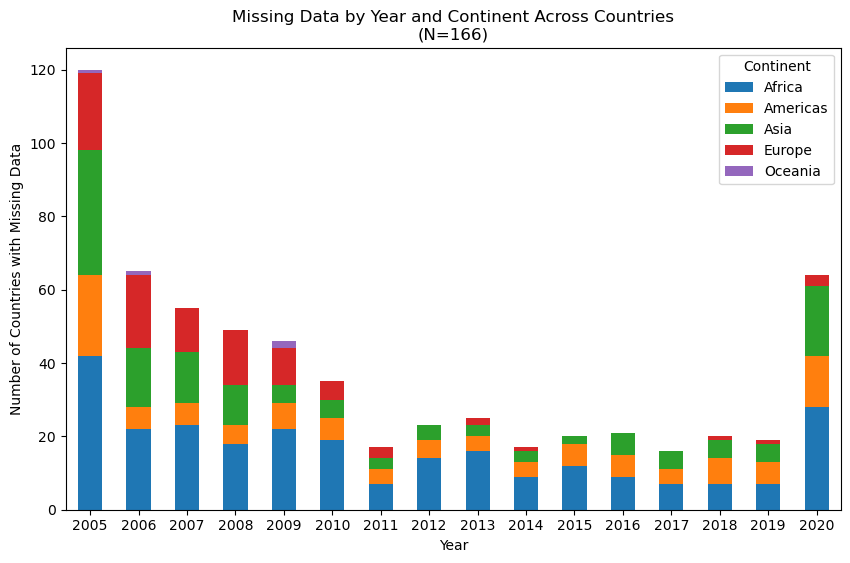

In [18]:
plt.figure(figsize=(10, 6))
years_missing_df_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

# Adjust x-tick labels to remove 'missing_' prefix and rotate if necessary
plt.gca().set_xticklabels([label.replace('missing_', '') for label in years_missing_df_pivot.index], rotation=0)

plt.xlabel('Year')
plt.ylabel('Number of Countries with Missing Data')
plt.title('Missing Data by Year and Continent Across Countries\n(N=166)')

plt.legend(title='Continent')
plt.show()

In [19]:
years_missing_df_grouped_reg = years_missing_df_long.groupby(['year', 'region']).sum().reset_index()

years_missing_df_pivot_reg = years_missing_df_grouped_reg.pivot(index='year', columns='region', values='missing')

In [20]:
years_missing_df_pivot_reg

region,Australia and New Zealand,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Middle Africa,Northern Africa,Northern America,Northern Europe,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
year,,,,,,,,,,,,,,,,,,,
missing_2005,1,5,7,5,14,2,4,6,4,0,7,10,8,5,7,7,13,12,3
missing_2006,1,0,2,1,6,2,5,4,5,1,3,3,1,3,4,8,4,8,4
missing_2007,0,4,0,2,8,0,1,3,4,0,4,2,1,3,3,3,5,8,4
missing_2008,0,2,1,1,5,0,6,4,4,0,0,2,1,3,2,7,2,7,2
missing_2009,2,4,1,0,5,1,3,4,2,0,3,2,1,4,2,1,7,1,3
missing_2010,0,3,1,1,9,0,0,3,0,0,4,2,1,3,2,0,4,1,1
missing_2011,0,1,1,0,2,0,0,1,0,0,2,2,1,1,2,0,3,0,1
missing_2012,0,3,1,0,5,0,0,2,0,0,0,1,1,3,2,0,4,1,0
missing_2013,0,1,1,0,6,0,0,2,2,0,1,2,0,3,1,0,3,2,1


### Creating an interactive map

Making the country names match between two datasets.

In [21]:
data = data.rename(columns={"Country name": "country"})

In [22]:
countries = countries.sort_values(by = "name")

data = data.sort_values(by = "country")

In [23]:
data_countries = data['country'].unique()

In [24]:
print(f"Geometries exist for {len(countries['name'])} countries (areas).")

print(f"Metric data exists for {len(data_countries)} countries.")

Geometries exist for 256 countries (areas).
Metric data exists for 166 countries.


Manually editing the country names to get rid of mismatches.

In [25]:
metric_countries = set(data['country'].unique())

geo_countries = set(countries['name'].unique())

#Find mismatches
mismatch_metric_to_geo = metric_countries - geo_countries
mismatch_geo_to_metric = geo_countries - metric_countries

print("Countries in metric data not in geo data:", mismatch_metric_to_geo)
print()
print("Countries in geo data not in metric data:", mismatch_geo_to_metric)

Countries in metric data not in geo data: {'Bosnia and Herzegovina', 'North Macedonia', 'Congo (Brazzaville)', 'Moldova', 'North Cyprus', 'South Korea', 'Taiwan Province of China', 'Syria', 'United States', 'Iran', 'Palestinian Territories', 'Tanzania', 'Congo (Kinshasa)', 'Russia', 'Libya', 'Hong Kong S.A.R. of China', 'United Kingdom', 'Kosovo', 'Somaliland region', 'Laos', 'Ivory Coast'}

Countries in geo data not in metric data: {'Saint Lucia', 'United States of America', 'Samoa', 'Sao Tome and Principe', 'Papua New Guinea', 'U.K. of Great Britain and Northern Ireland', 'The former Yugoslav Republic of Macedonia', 'British Virgin Islands', 'Seychelles', 'Puerto Rico', 'Norfolk Island', 'Kiribati', 'Eritrea', "Côte d'Ivoire", 'Svalbard and Jan Mayen Islands', 'Glorioso Islands', 'Jersey', 'American Samoa', 'Tonga', 'Vanuatu', 'Andorra', 'Democratic Republic of the Congo', 'Syrian Arab Republic', 'Midway Is.', 'Micronesia (Federated States of)', 'Niue', 'Republic of Korea', 'Taiwan',

In [26]:
rename_dict = {
    'Congo (Brazzaville)': 'Republic of the Congo',
    'Congo (Kinshasa)': 'Congo',
    'Iran': 'Iran (Islamic Republic of)',
    'Moldova': 'Moldova, Republic of',
    'North Macedonia': 'The former Yugoslav Republic of Macedonia',
    'Ivory Coast': "Côte d'Ivoire", 
    'Tanzania': 'United Republic of Tanzania',  
    'Libya': 'Libyan Arab Jamahiriya', 
    'Bosnia and Herzegovina': 'Bosnia & Herzegovina',  
    'Russia': 'Russian Federation', 
    'United States': 'United States of America', 
    'United Kingdom': 'U.K. of Great Britain and Northern Ireland', 
    'Taiwan Province of China': 'Taiwan', 
    'South Korea': 'Republic of Korea', 
    'Syria': 'Syrian Arab Republic'
}

In [27]:
data['country'] = data['country'].replace(rename_dict)

Defining the map.

In [28]:
#Defining the interactive widgets
years = data['year'].unique()
metrics = [col for col in data.columns if col not in ['year', 'country']]

year_slider = widgets.IntSlider(
    value=max(years),
    min=min(years),
    max=max(years),
    step=1,
    description='Year:',
    continuous_update=False
)

metric_dropdown = widgets.Dropdown(
    options=metrics,
    description='Metric:'
)

In [29]:
def create_map(year, metric):
    
    #Merge data with the GeoDataFrame
    merged = countries.merge(data[data['year'] == year][['country', metric]], 
                             left_on='name', right_on='country', how='left')


    m = folium.Map(location=[25, 0], zoom_start=1.5)

    #Defining a function to return the tooltip text
    def tooltip_text(feature):
        country = feature['properties']['name']
        value = merged.loc[merged['name'] == country, metric].values[0]
        return f'{country}: {value}'

    # Add the countries to the map with tooltips
    folium.Choropleth(
        geo_data=merged.__geo_interface__,
        name='choropleth',
        data=merged,
        columns=['name', metric],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=metric
    ).add_to(m)

    #Adding a GeoJson tooltip
    folium.GeoJson(
        data=merged.__geo_interface__,style_function=lambda x: {'color':'transparent', 'fillColor':'transparent', 'weight':0},
        tooltip=folium.GeoJsonTooltip(fields=['name', metric])
    ).add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

In [30]:
interactive_map = widgets.interactive(create_map, year=year_slider, metric=metric_dropdown)

display(interactive_map)

interactive(children=(IntSlider(value=2020, continuous_update=False, description='Year:', max=2020, min=2005),…